In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


In [16]:
features = pd.read_csv('data/Table_EV6/Table_EV6.tsv', sep='\t')

features = features.iloc[:, 4:]
features = features[[col for col in features.columns if not any(id in col for id in ["MiRNA","RBP"])]]

ptr = pd.read_csv('data/Table_EV3/Table_EV3.tsv', sep='\t')
ptr = ptr[[col for col in ptr.columns if "PTR" in col]]

print(features.shape)
print(ptr.shape)

(11575, 211)
(11575, 29)


In [17]:
ptr = ptr.apply(pd.to_numeric, errors='coerce')
print(ptr.shape)

valid_idx = ptr.notna().all(axis=1)
ptr = ptr[valid_idx]
features = features.loc[valid_idx]

model = LinearRegression()
model.fit(features, ptr)


coefs = model.coef_       
intercepts = model.intercept_

pred = model.predict(features)  

(11575, 29)


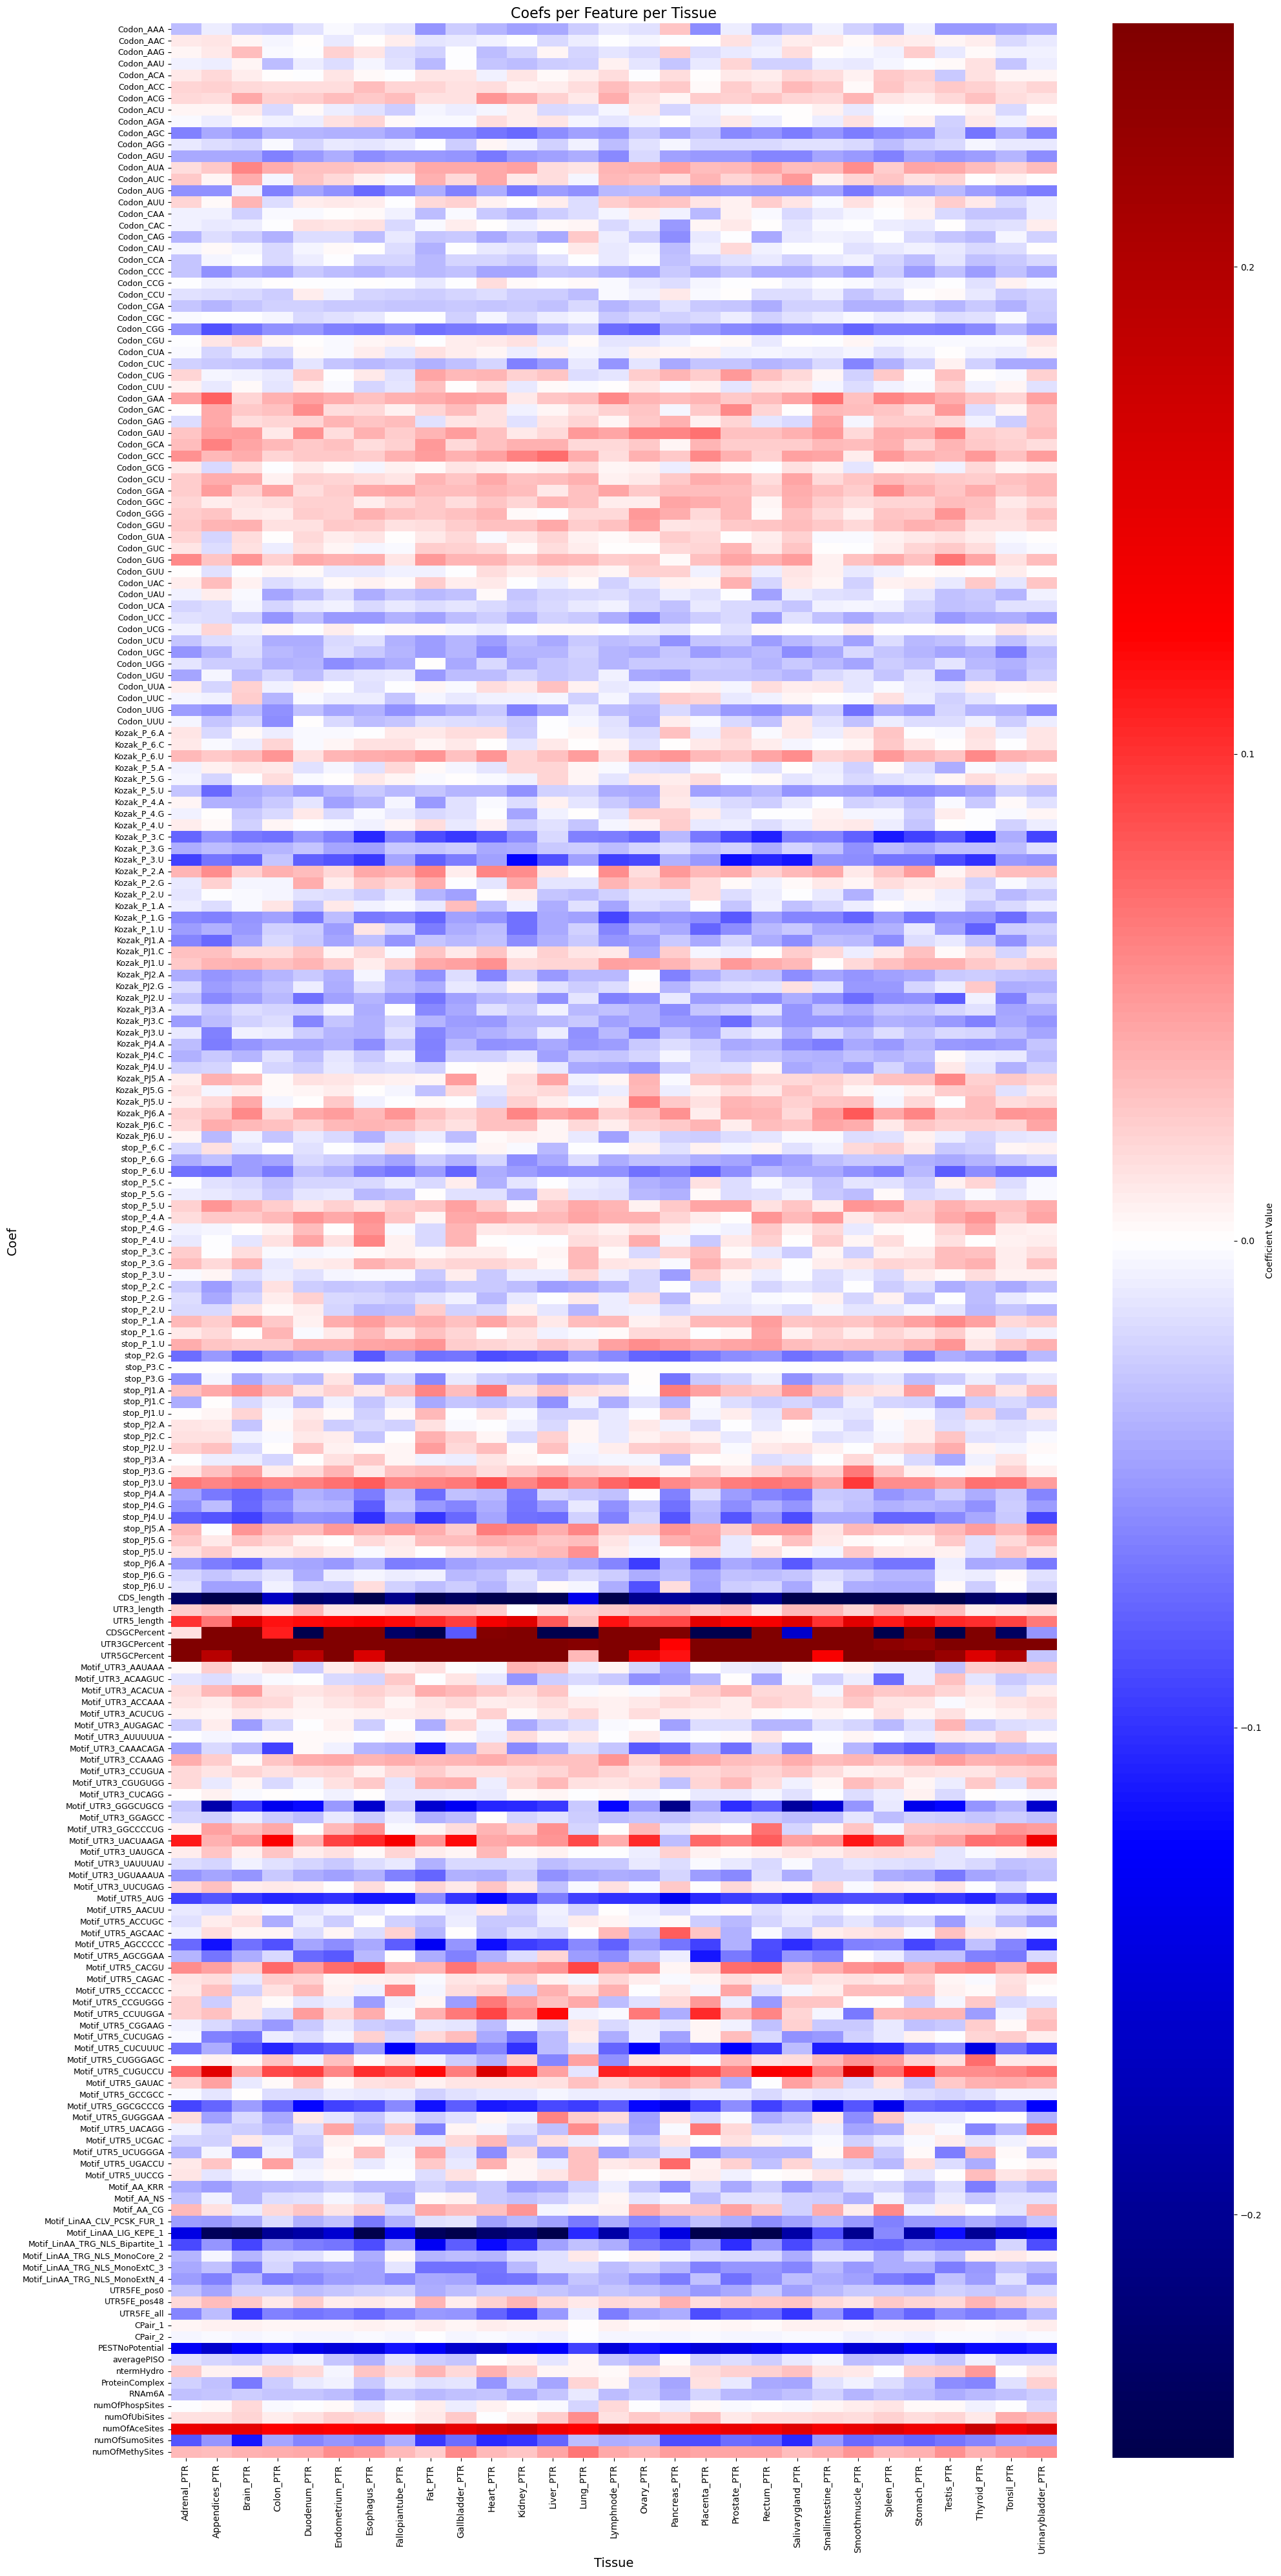

In [18]:
coefs_df = pd.DataFrame(coefs.T,index=features.columns, columns=list(ptr.columns))
plt.figure(figsize=(20, 40))  # Increase size (width, height) as needed

sns.heatmap(
    coefs_df,
    #annot=True,
    fmt=".2e",                  # scientific notation for tiny values
    cmap="seismic",             # strong diverging color map
    center=0,                   # ensures 0 is the neutral color
    vmin=-0.25, vmax=0.25,      # manually set color range to highlight small differences
    #annot_kws={"size": 6},
    cbar_kws={'label': 'Coefficient Value'}
)

plt.title("Coefs per Feature per Tissue", fontsize=16)
plt.xlabel("Tissue", fontsize=14)
plt.ylabel("Coef", fontsize=14)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

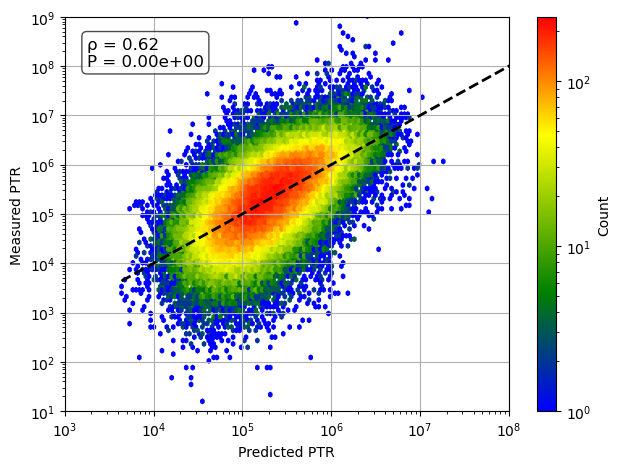

In [19]:
predf = pred.flatten()
ptrf = ptr.values.flatten()
rho, pval = spearmanr(predf, ptrf)


pred_exp = 10**predf
ptr_exp = 10**ptrf

colors = [
    (0.0, "blue"),
    (0.3, "green"),
    (0.7, "yellow"),
    (1  , "red"),
]

custom_cmap = LinearSegmentedColormap.from_list("blue_yellow_red", colors)

hb =plt.hexbin(pred_exp, ptr_exp,gridsize=100, 
           xscale = 'log',yscale = 'log',cmap=custom_cmap, bins = 'log' ,mincnt=1  )

cb = plt.colorbar(hb)
cb.set_label('Count')

plt.xlim(1e3, 1e8)
plt.ylim(10, 1e9)


m, b = np.polyfit(predf, ptrf, 1)
x_fit = np.linspace(predf.min(), ptrf.max(), 100)
y_fit = m * x_fit + b
plt.plot(10**x_fit, 10**y_fit, color='black', linestyle='--', linewidth=2, label='Fit line')


plt.text(
    0.05, 0.95, f'ρ = {rho:.2f}\nP = {pval:.2e}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
)
plt.xlabel('Predicted PTR')
plt.ylabel('Measured PTR')
plt.grid()
plt.tight_layout()
plt.show()

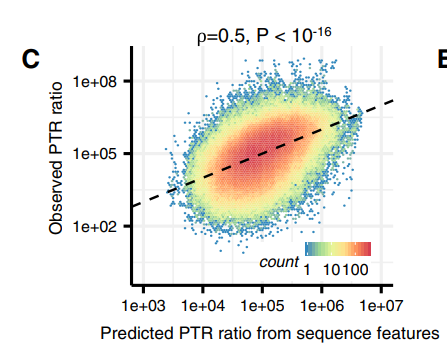

In [20]:
#explained variance without cross-val
def r2(obs, pred):
    ss_res = np.sum((obs - pred) ** 2)           
    ss_tot = np.sum((obs - np.mean(pred)) ** 2)  
    r2 = 1 - (ss_res / ss_tot)
    return r2

r2(ptr.values,pred)

np.float64(0.3761142875329695)

In [21]:
feat_array = features.values
ptr_array = ptr.values

kf = KFold(n_splits=10, shuffle=True, random_state=42)


r2_scores = []
for tissue_idx in range(ptr_array.shape[1]):
    ptr_tissue = ptr_array[:, tissue_idx]
    scores = cross_val_score(LinearRegression(), feat_array, ptr_tissue, cv=kf, scoring='r2')
    r2_scores.append(scores)

# Convert to array and average
r2_scores = np.array(r2_scores) 
mean_r2_per_tissue = r2_scores.mean(axis=1)
overall_mean_r2 = r2_scores.mean()

print(overall_mean_r2)
print(pd.DataFrame({
    'Tissue': list(ptr.columns),
    'Mean R²': mean_r2_per_tissue
}))



0.29847966835291945
                Tissue   Mean R²
0          Adrenal_PTR  0.330384
1       Appendices_PTR  0.250744
2            Brain_PTR  0.340992
3            Colon_PTR  0.252211
4         Duodenum_PTR  0.280539
5      Endometrium_PTR  0.294510
6        Esophagus_PTR  0.294375
7    Fallopiantube_PTR  0.299095
8              Fat_PTR  0.280816
9      Gallbladder_PTR  0.287683
10           Heart_PTR  0.277105
11          Kidney_PTR  0.351827
12           Liver_PTR  0.282535
13            Lung_PTR  0.298471
14       Lymphnode_PTR  0.343869
15           Ovary_PTR  0.223944
16        Pancreas_PTR  0.229465
17        Placenta_PTR  0.291854
18        Prostate_PTR  0.264306
19          Rectum_PTR  0.317753
20   Salivarygland_PTR  0.338803
21  Smallintestine_PTR  0.299889
22    Smoothmuscle_PTR  0.300415
23          Spleen_PTR  0.310403
24         Stomach_PTR  0.324388
25          Testis_PTR  0.322880
26         Thyroid_PTR  0.333504
27          Tonsil_PTR  0.331889
28  Urinarybladder_PTR 

In [22]:

kf = KFold(n_splits=10, shuffle=True, random_state=42)

n_features = feat_array.shape[1]
n_tissues = ptr_array.shape[1]

r2_per_feature = np.zeros((n_features, n_tissues))

for f_idx in range(n_features):
    X_single = feat_array[:, f_idx].reshape(-1, 1)  

    for tissue_idx in range(n_tissues):
        y = ptr_array[:, tissue_idx]
        scores = cross_val_score(LinearRegression(), X_single, y, cv=kf, scoring='r2')
        r2_per_feature[f_idx, tissue_idx] = scores.mean()  

print(r2_per_feature.shape)

(211, 29)


(211, 29)


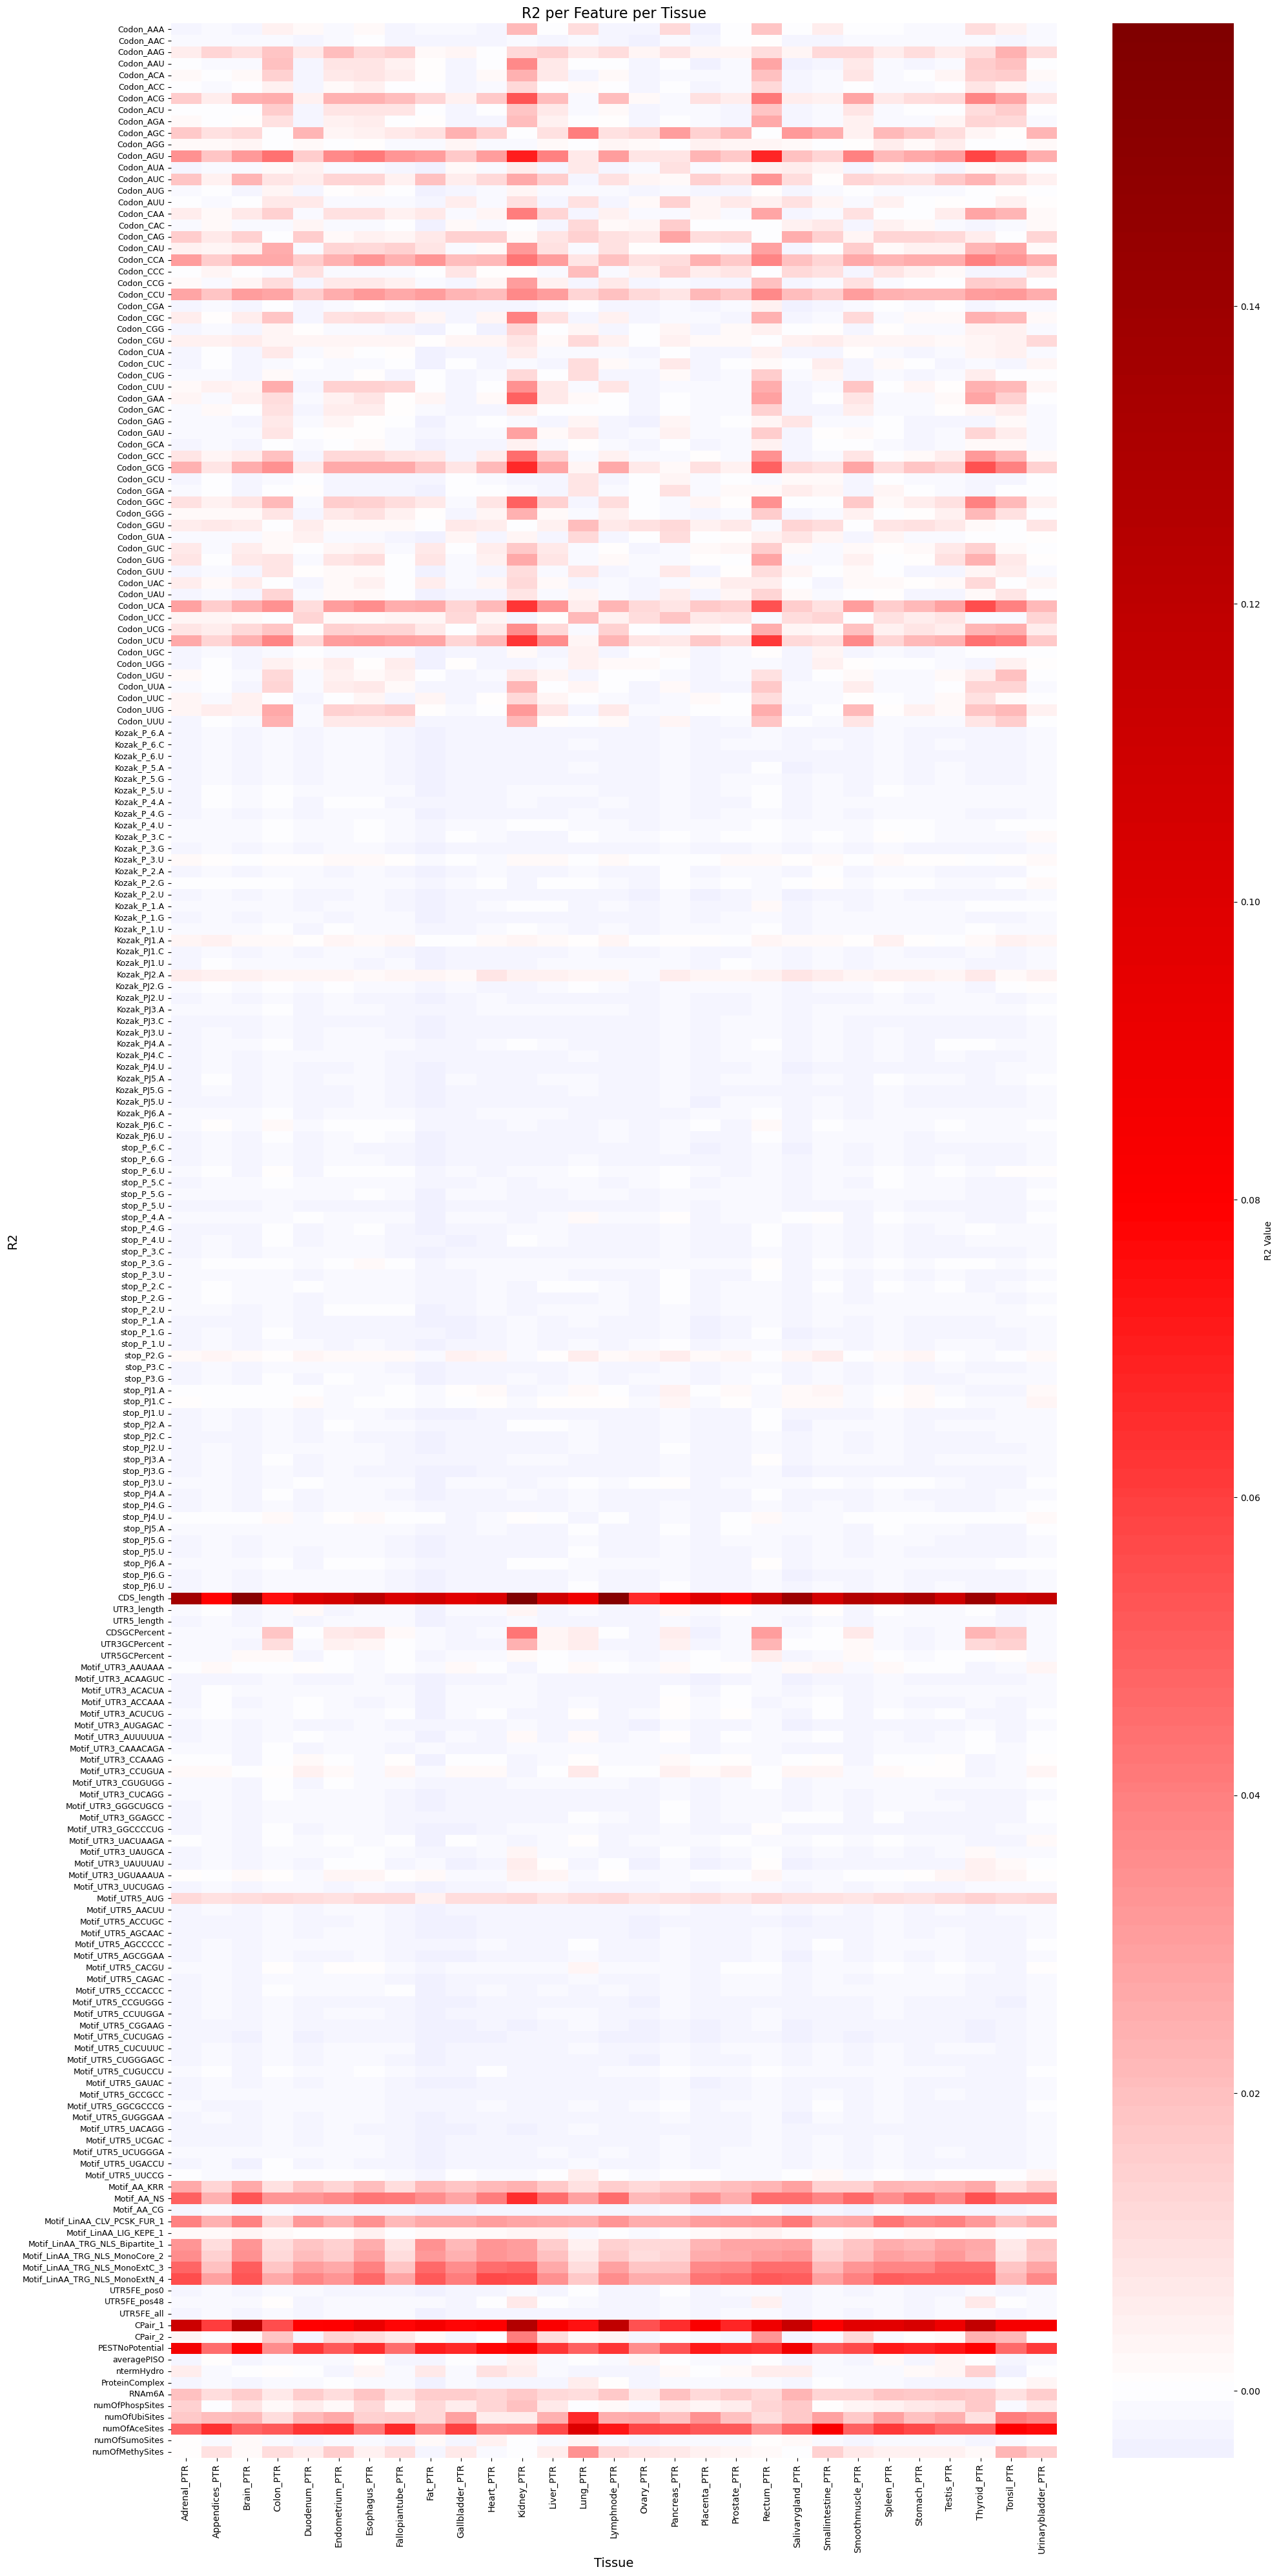

In [23]:
r2_per_feature_df = pd.DataFrame(r2_per_feature,index=features.columns, columns=list(ptr.columns))
#r2_per_feature_df = r2_per_feature_df.loc[[row for row in r2_per_feature_df.index if not any(id in row for id in ["Codon","Kozak","stop"])]]
print(r2_per_feature_df.shape)

plt.figure(figsize=(20, 40))  # Increase size (width, height) as needed

sns.heatmap(
    r2_per_feature_df,
    cmap="seismic",             
    center=0,                 
    #vmin=-0.25, vmax=0.25,      
    #annot_kws={"size": 6},
    cbar_kws={'label': 'R2 Value'}
)

plt.title("R2 per Feature per Tissue", fontsize=16)
plt.xlabel("Tissue", fontsize=14)
plt.ylabel("R2", fontsize=14)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()